# Embedding layer analysis

Analyze the embedding layer of a model using cluster analysis (tSNE, UMAP).

In [1]:
import os
import numpy as np
import pandas as pd
import yaml

import tensorflow.keras
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

import matplotlib.pyplot as plt

In [2]:
plt.style.use('bmh')

In [3]:
from test import create_agents
from utils.dataprep import load_emb_pickled

In [4]:
def load_agents(model_path, image_shape):
    settings_path = os.path.join(model_path, "settings.yml")
    print(f"Loading model from {settings_path}")
    with open(settings_path) as f:
        settings = yaml.safe_load(f)
    settings["image_shape"] = image_shape
    agent1, agent2 = create_agents(**settings)
    try:
        agent1.load(os.path.join(model_path, "agent1"))
        agent2.load(os.path.join(model_path, "agent2"))
    except Exception as e:
        print(f"Cannot load agents: {e}")
        
    # extract models
    if settings["role_mode"] == "static":
        agents = (agent1, agent2)
    else:
        agents = (agent1.components["sender"], agent2.components["sender"])
    
    models = []
    for agent in agents:
        for layer in agent.model.layers:
            if layer.name.endswith("image_embedding"):
                break
        x = agent.model.input[0]
        y = layer(x) 
        model = tensorflow.keras.models.Model(x, y)
        models.append(model)
    
    return models


In [5]:
dataset = "data/big/mcrae-wordnet-vgg16.32bit"
metadata, embeddings = load_emb_pickled(dataset)
filenames = metadata.get("fnames")
categories = metadata.get("categories")
classes = metadata.get("classes")
class_idx = metadata.get("class_idx")
class_names = metadata.get("class_names")

Loading features from data/big/mcrae-wordnet-vgg16.32bit.npy.gz
Loading metadata from data/big/mcrae-wordnet-vgg16.32bit.meta.pkl
4 categories found.


In [5]:
models_base_path = "top-models"
model_folder = "e1-explore-temp-210519-222000"

model1, model2 = load_agents(
    os.path.join(models_base_path, model_folder), 
    image_shape=[len(embeddings[0])]
)

Loading model from top-models/e1-explore-temp-210519-222000/settings.yml
Loading weights from top-models/e1-explore-temp-210519-222000/agent1
Loading weights from top-models/e1-explore-temp-210519-222000/agent2


In [21]:
embedding_output = model1.predict(embeddings)

In [22]:
tsne = TSNE(n_components=2, perplexity=30)
tsne_out = tsne.fit_transform(embedding_output)

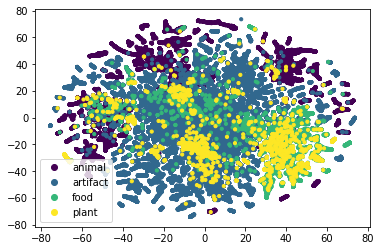

In [23]:
scatter = plt.scatter(*tsne_out.T, c=class_idx, s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=list(class_names))
plt.savefig(
    os.path.join(models_base_path, model_folder, "embedding-tsne.png"), 
    dpi=200
)

In [24]:
umap_out = UMAP(n_components=2, n_neighbors=30).fit_transform(embedding_output)

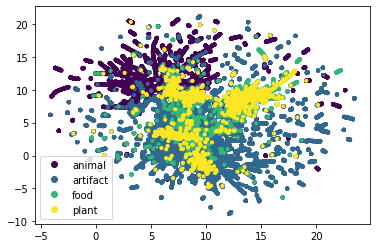

In [25]:
scatter = plt.scatter(*coords_2.T, c=class_idx, s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=list(class_names))
plt.savefig(
    os.path.join(models_base_path, model_folder, "embedding-umap.png"), 
    dpi=200
)

In [11]:
def reduce_and_plot(models_base_path, model_folder, class_idx, class_names):
    model_path = os.path.join(models_base_path, model_folder)
    print(f">>>> Processing {model_path} ...")
    model1, model2 = load_agents(
        model_path, 
        image_shape=[len(embeddings[0])]
    )
    print("Predicting... ", end="")
    embedding_output = model1.predict(embeddings)
    print("Computing tSNE... ", end="")
    tsne = TSNE(n_components=2, perplexity=30)
    tsne_out = tsne.fit_transform(embedding_output)
    scatter = plt.scatter(*tsne_out.T, c=class_idx, s=10)
    print("Saving results", end="")
    np.save(
        os.path.join(model_path, "embedding.tsne.npy"), 
        tsne_out
    )
    plt.legend(handles=scatter.legend_elements()[0], labels=list(class_names))
    print(", plot... ", end="")
    plt.savefig(
        os.path.join(model_path, "embedding.tsne.png"), 
        dpi=200
    )
    plt.clf()
    print("Computing UMAP... ", end="")
    umap_out = UMAP(n_components=2, n_neighbors=30).fit_transform(embedding_output)
    scatter = plt.scatter(*umap_out.T, c=class_idx, s=10)
    print("Saving results", end="")
    np.save(
        os.path.join(model_path, "embedding.umap.npy"), 
        umap_out
    )
    plt.legend(handles=scatter.legend_elements()[0], labels=list(class_names))
    print(", plot... ", end="")
    plt.savefig(
        os.path.join(model_path, "embedding.umap.png"), 
        dpi=200
    )
    plt.clf()
    print("DONE")

In [12]:
models_base_path = "top-models"
folders = """
e1-explore-temp-210519-222000
e3-4images-210523-022405
e3-6images-210523-031950
e4-switch-2img-210523-142302
e4-switch-2img-210524-124621
e4-switch-4img-210523-154352
e4-switch-4img-210524-140539
e4-switch-6img-210524-200612
e4-switch-6img-210524-204656
""".strip().split("\n")

for folder in folders:
    reduce_and_plot(models_base_path, folder, class_idx, class_names)


>>>> Processing top-models/e1-explore-temp-210519-222000 ...
Loading model from top-models/e1-explore-temp-210519-222000/settings.yml
Loading weights from top-models/e1-explore-temp-210519-222000/agent1
Loading weights from top-models/e1-explore-temp-210519-222000/agent2
Predicting... Computing tSNE... Saving results, plot... Computing UMAP... Saving results, plot... DONE
>>>> Processing top-models/e3-4images-210523-022405 ...
Loading model from top-models/e3-4images-210523-022405/settings.yml
Loading weights from top-models/e3-4images-210523-022405/agent1
Loading weights from top-models/e3-4images-210523-022405/agent2
Predicting... Computing tSNE... Saving results, plot... Computing UMAP... Saving results, plot... DONE
>>>> Processing top-models/e3-6images-210523-031950 ...
Loading model from top-models/e3-6images-210523-031950/settings.yml
Loading weights from top-models/e3-6images-210523-031950/agent1
Loading weights from top-models/e3-6images-210523-031950/agent2
Predicting... Comp

<Figure size 432x288 with 0 Axes>

In [6]:
def plot_saved(models_base_path, model_folders, class_idx, class_names, file_name, labels):
    fig = plt.figure()
#     plt.tight_layout()
    fig.set_size_inches(12, 12)
    grid = fig.add_gridspec(*np.asarray(model_folders).shape, hspace=0.03, wspace=0.03)
    subplots = grid.subplots(sharex='col', sharey='row')
    for folder, label, ax in zip(np.ravel(model_folders), np.ravel(labels), np.ravel(subplots)):
        model_path = os.path.join(models_base_path, folder)
        
        scatter_path = os.path.join(models_base_path, folder, file_name)
        data = np.load(scatter_path)
        scatter = ax.scatter(*data.T, c=class_idx, s=10)
        ax.text(.5, .95, label,
            horizontalalignment='center',
            transform=ax.transAxes
        )
    plt.legend(handles=scatter.legend_elements()[0], labels=list(class_names), loc='lower right')

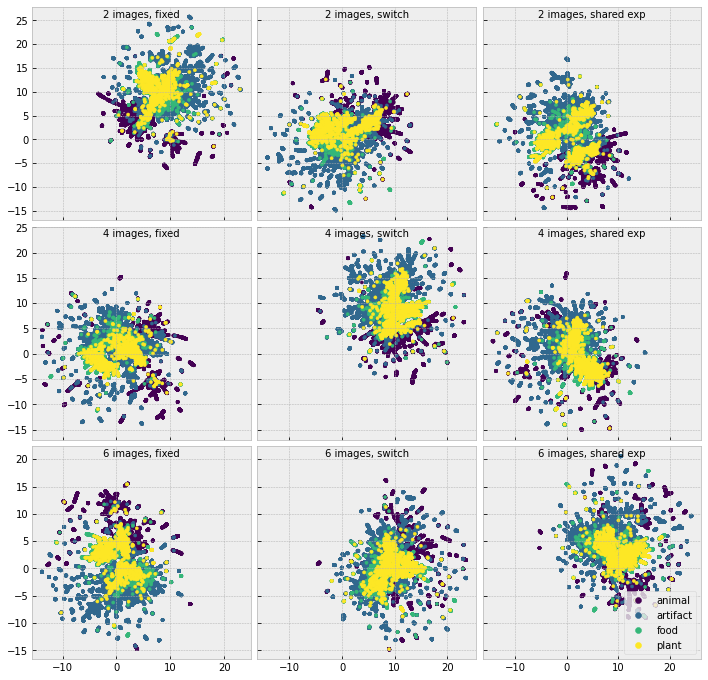

In [8]:
models_base_path = "top-models"
folders = """
e1-explore-temp-210519-222000
e4-switch-2img-210523-142302
e4-switch-2img-210524-124621

e3-4images-210523-022405
e4-switch-4img-210523-154352
e4-switch-4img-210524-140539

e3-6images-210523-031950
e4-switch-6img-210524-200612
e4-switch-6img-210524-204656
""".strip()
folders = [
    group.split("\n")
    for group in folders.split("\n\n")
]

labels = """
2 images, fixed
2 images, switch
2 images, shared exp

4 images, fixed
4 images, switch
4 images, shared exp

6 images, fixed
6 images, switch
6 images, shared exp
""".strip()
labels = [
    group.split("\n")
    for group in labels.split("\n\n")
]
plot_saved(models_base_path, folders, class_idx, class_names, "embedding.umap.npy", labels)

plt.savefig(os.path.join(models_base_path, f"embedding.umap.png"), dpi=200, bbox_inches="tight")